In [16]:
# ============================== Use google drive ===================================================
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

import os
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Colab Notebooks',
 'Data',
 '4f8be592-07d0-4133-bf53-c61ac948ebbf.pdf',
 'Dubliners by James Joyce [full text].pdf',
 'ModelStructure_CNN_LSTM.png',
 'keras_model3.h5']

In [17]:
# scrapping data files path  
data_address = "Data/20201020_Epileptic_Seizure_Recognition/Epileptic Seizure Recognition.csv"
display(data_address)
# ============================== Use google drive END ===================================================

'Data/20201020_Epileptic_Seizure_Recognition/Epileptic Seizure Recognition.csv'

In [18]:
# ============================== Importing the libraries ===================================================
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras import layers
from keras import regularizers
import os
import keras

import keras.backend as K
from keras.utils import plot_model

from keras.callbacks import LearningRateScheduler
# ============================== Importing the libraries END ===================================================

In [19]:
# ============================== Load the Dataset ===================================================
df = pd.read_csv(data_address, header=0, index_col=0)
df1 = df.drop(["y"], axis=1)
lbls = df["y"].values - 1
# ============================== Load the Dataset END ===================================================

In [20]:
# ============================== Data Pre-processing ===================================================
wave = np.zeros((11500, 178))

z = 0
for index, row in df1.iterrows():
    wave[z, :] = row
    z+=1

mean = wave.mean(axis=0)
wave -= mean
std = wave.std(axis=0)
wave /= std

def one_hot(y):
    lbl = np.zeros(5)
    lbl[y] = 1
    return lbl

target = []
for value in lbls:
    target.append(one_hot(value))
target = np.array(target)
wave = np.expand_dims(wave, axis=-1)
# ============================== Data Pre-processing END ===================================================

In [21]:
# ============================== Develop NN Models ===================================================
model = Sequential()
model.add(layers.Conv1D(64, 15, strides=2, input_shape=(178, 1), use_bias=False))
model.add(layers.ReLU())
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, 3))
model.add(layers.Conv1D(64, 3, strides=2))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation="softmax"))
model.summary()
#plot_model(model, to_file='ModelStructure_CNN_LSTM.png', show_shapes=True)

save_path = './keras_model3.h5'

if os.path.isfile(save_path):
    model.load_weights(save_path)
    print('reloaded.')

adam = keras.optimizers.Adam()

model.compile(optimizer=adam,
              loss="categorical_crossentropy", 
              metrics=["acc"])

# 计算学习率
def lr_scheduler(epoch):
    # 每隔100个epoch，学习率减小为原来的0.5
    if epoch % 100 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
        print("lr changed to {}".format(lr * 0.5))
    return K.get_value(model.optimizer.lr)

lrate = LearningRateScheduler(lr_scheduler)

history = model.fit(wave, 
                    target, 
                    epochs=1000,
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=2, 
                    callbacks=[lrate])

model.save_weights(save_path)
# ============================== Develop NN Models END ===================================================


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 82, 64)            960       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 82, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 64)            12352     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 39, 64)            12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 64)            256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 64)           

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


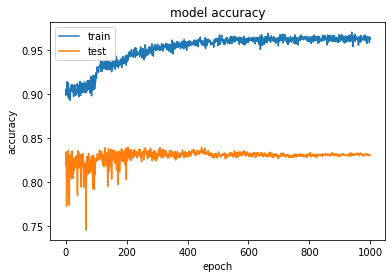

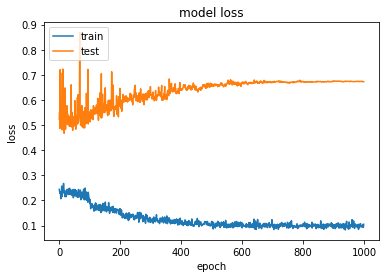

In [22]:
# ============================== show the process ===================================================
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# ============================== show the process END ===================================================